# IMA pipeline tutorial

### by Patrick Kavanagh (DIAS, Ireland) August 26th 2017

This notebook demonstrates the execution of the level 2A, 2B and 3 pipelines for IMA data in Python using the jwst step classes.

Documentation on each pipeline step can be found here:

http://ssb.stsci.edu/doc/jwst_dev/

The pipeline steps are:

2A: dq_init, saturation, linearity, RSCD, lastframe, dark_current, refpix, jump, ramp_fitting

2B: assign_wcs, flat_field, photom

3:  tweakreg_catalog, tweakreg, skymatch, outlier_detection, resample, source_catalog

The data files used in this notebook is a MIRISim simulation of field of point sources whose spectra are described by blackbody models.

The simulated observation is a four-point dither on the source with the F1130W filter. We will demonstrate the level 2A and 2B pipelines on a single file and the level 3 pipeline on the set of dither positions.

#### imports

In [1]:
import os, glob, shutil
from subprocess import call

import numpy as np
from astropy.io import fits
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

from jwst import datamodels

%matplotlib inline
# %matplotlib notebook # if you want interactive plots

#### Set input file, output directory for step outputs:

In [2]:
# set input filenames and directory. In this example, the files are located in a folder called 'IMA_demo_data'
input_dir = 'IMA_demo_data'
input_files = glob.glob(os.path.join(input_dir,'*.fits'))

# set the output directory name
output_dir = input_dir + '_steps_output'

# if the output directory exists, delete it
if os.path.exists(output_dir): shutil.rmtree(output_dir)

# create the output directory
os.mkdir(output_dir)

#### print some information about the input file. 
Note that ground test data and MIRISim data will differ here. We can distinguish between the two using the 'ORIGIN' header keyword. Converted ground test data will always have 'STScI' as the origin.

Also note that there is currently a problem running MIRISim data step-wise through the pipeline. One must remove some of the extensions. This has been taken care of in the following cell. This issue has been reported to STScI and this notebook will be updated when it is resolved.

In [3]:
# print some info on input file
with fits.open(input_files[0]) as hdulist:
    
    if hdulist[0].header['ORIGIN'] == 'STScI':
        # specific information on instrument/exposure
        identifier = hdulist[0].header['OBS_ID']
        detector = hdulist[0].header['DETECTOR']
        im_filter = hdulist[0].header['FILTER']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        channel = hdulist[0].header['CHANNEL']
        band = hdulist[0].header['BAND']
        print "ID\t\t\t Detector\t Filter\t subAr\t nInts\t nGrps\t rdPatt\t ExpTime (s)"
        print "--------------------------------------------------------------------------------------------------"
        print "%s\t %s\t %s\t %s\t %d\t %d\t %s\t %0.1f" % (identifier,detector,im_filter,subArr,nInts,nGroups,readPatt,expTime)
        print "\n\n"
        
    else:
        # specific information on instrument/exposure
        detector = hdulist[0].header['DETECTOR']
        im_filter = hdulist[0].header['FILTER']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        print "ID\t Detector\t Filter\t subAr\t nInts\t nGrps\t rdPatt\t ExpTime (s)"
        print "--------------------------------------------------------------------------------------------------"
        print "MIRISim\t %s\t %s\t %s\t %d\t %d\t %s\t %0.1f" % (detector,im_filter,subArr, nInts,nGroups,readPatt,expTime)
        print "\n\n"

    # fits extension table
    hdulist.info()

ID	 Detector	 Filter	 subAr	 nInts	 nGrps	 rdPatt	 ExpTime (s)
--------------------------------------------------------------------------------------------------
MIRISim	 MIRIMAGE	 F1130W	 FULL	 2	 50	 FAST	 277.5



Filename: IMA_demo_data/det_image_1_MIRIMAGE_F1130Wexp1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     152   ()      
  1  SCI           1 ImageHDU        14   (1032, 1024, 50, 2)   float32   
  2  REFOUT        1 ImageHDU        14   (258, 1024, 50, 2)   float32   
  3  PIXELDQ       1 ImageHDU        10   (1032, 1024)   int32 (rescales to uint32)   
  4  PIXELDQ_DEF    1 BinTableHDU     17   29R x 4C   [J, J, 40A, 128A]   
  5  ASDF          1 ImageHDU         7   (533679145,)   uint8   


## DQ_INIT step ===================================================
This step creates the PIXELDQ, GROUPDQ and ERR extensions in the ramp file 
which are copied from the calibration file. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/dq_init/index.html


### DQ_INIT: load module and show options

In [4]:
# import the step
from jwst.dq_init import dq_init_step

# print the description and options
print dq_init_step.DQInitStep.__doc__
print dq_init_step.DQInitStep.spec




    DQInitStep:  Initialize the Data Quality extension from the
    mask reference file.  Also initialize the error extension

    

    pre_hooks = string_list(default=list())
    post_hooks = string_list(default=list())
    output_dir = string(default=None)       # Directory path for output files
    output_file = output_file(default=None) # File to save output to.
    skip = boolean(default=False)           # Skip this step
    save_results = boolean(default=False)   # Force save results
    suffix = string(default=None)           # Default suffix for output files
    


### DQ_INIT: run step

In [5]:
# run the dq_init step
dm = dq_init_step.DQInitStep.call(input_files[0], save_results=True, output_dir=output_dir, output_file='dq_init_out.fits')

2017-08-30 11:33:08,002 - stpipe.DQInitStep - INFO - DQInitStep instance created.
2017-08-30 11:33:11,056 - stpipe.DQInitStep - INFO - Prefetch for MASK reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_mask_0019.fits'.
2017-08-30 11:33:11,106 - stpipe.DQInitStep - INFO - Step DQInitStep running with args ('IMA_demo_data/det_image_1_MIRIMAGE_F1130Wexp1.fits',).
2017-08-30 11:33:12,987 - stpipe.DQInitStep - INFO - Using MASK reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_mask_0019.fits
2017-08-30 11:33:23,097 - stpipe.DQInitStep - INFO - Saving file IMA_demo_data_steps_output/dq_init_out.fits
2017-08-30 11:33:24,838 - stpipe.DQInitStep - INFO - Step DQInitStep done


### DQ_INIT:  output check

1. check the output datamodel to show values in the new extensions, check that some pixels have been assigned new flags from the mask file

In [6]:
# check the calibration step information
print'Check dq_init step information status:'
print dm.meta.cal_step.dq_init

# print unique values in the PIXELDQ extension
print "\nDQ flags values in PIXELDQ:"
print ', '.join(map(str, np.unique(dm.pixeldq)))

# print unique values in the GROUPDQ extension
print "\nDQ flags values in GROUPDQ extension:"
print ', '.join(map(str, np.unique(dm.groupdq)))

Check dq_init step information status:
COMPLETE

DQ flags values in PIXELDQ:
0, 512, 1025, 2049, 16385, 16777216, 16777217, 16777729

DQ flags values in GROUPDQ extension:
0


### DQ_INIT:  output plots

1. plot the science data

2. plot the PIXEL_DQ extension to show which pixels have been flagged

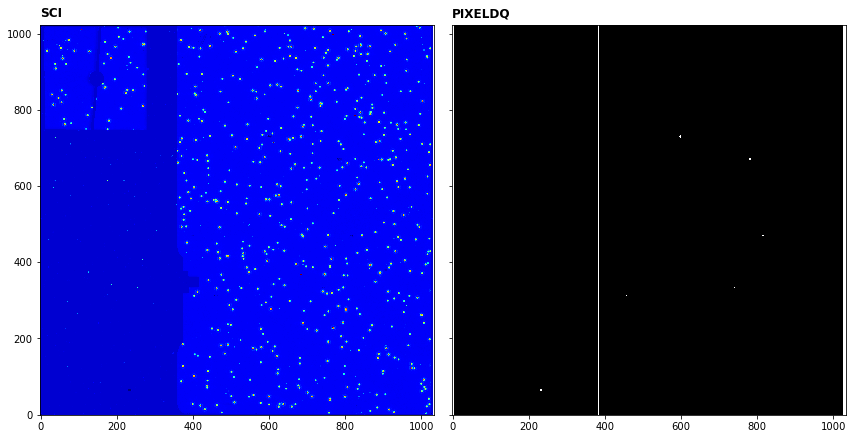

In [7]:
# plot--------------------------------------
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# show last frame of first integration
axs[0].imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=5e4))
axs[0].annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

# plot the PIXEL_DQ frame
axs[1].imshow(dm.pixeldq, cmap='gray', interpolation='nearest', origin='lower', vmin=0, vmax=1)
axs[1].annotate('PIXELDQ', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()
    

## SATURATION step ============================================
The saturation step flags saturated pixel for each integration by reading the calibration reference
file that specifies the saturation level for each pixel. The saturation flags are set in the fram of the GROUPDQ extension where the pixel reaches saturation. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/saturation/index.html


### SATURATION: load module and show options

In [8]:
# import the step
from jwst.saturation import saturation_step

# print the description and options
print saturation_step.SaturationStep.__doc__
print saturation_step.SaturationStep.spec



    This Step sets saturation flags.
    

    pre_hooks = string_list(default=list())
    post_hooks = string_list(default=list())
    output_dir = string(default=None)       # Directory path for output files
    output_file = output_file(default=None) # File to save output to.
    skip = boolean(default=False)           # Skip this step
    save_results = boolean(default=False)   # Force save results
    suffix = string(default=None)           # Default suffix for output files
    


### SATURATION: run step

In [9]:
# run the saturation step
dm = saturation_step.SaturationStep.call(dm, save_results=True, output_dir=output_dir, output_file='saturation_out.fits')

2017-08-30 11:33:27,101 - stpipe.SaturationStep - INFO - SaturationStep instance created.
2017-08-30 11:33:27,771 - stpipe.SaturationStep - INFO - Prefetch for SATURATION reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_saturation_0019.fits'.
2017-08-30 11:33:27,836 - stpipe.SaturationStep - INFO - Step SaturationStep running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x11305c710>,).
2017-08-30 11:33:28,321 - stpipe.SaturationStep - INFO - Using SATURATION reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_saturation_0019.fits
2017-08-30 11:33:29,932 - stpipe.SaturationStep - INFO - Saving file IMA_demo_data_steps_output/saturation_out.fits
2017-08-30 11:33:31,974 - stpipe.SaturationStep - INFO - Step SaturationStep done


### SATURATION:  output check

1. saturated pixels will be flagged in the GROUPDQ extension with the number 2. Check that some pixels in this extension are now flagged as saturated

In [10]:
# check the calibration step information
print'Check saturation step information status:'
print dm.meta.cal_step.saturation

# print unique values in the GROUPDQ extension
print "\nDQ flags values in GROUPDQ extension:"
print ', '.join(map(str, np.unique(dm.groupdq)))
    

Check saturation step information status:
COMPLETE

DQ flags values in GROUPDQ extension:
0, 2


### SATURATION:  output plots

1. plot the science data

2. plot the GROUP_DQ extension to show which pixels have been flagged as saturated

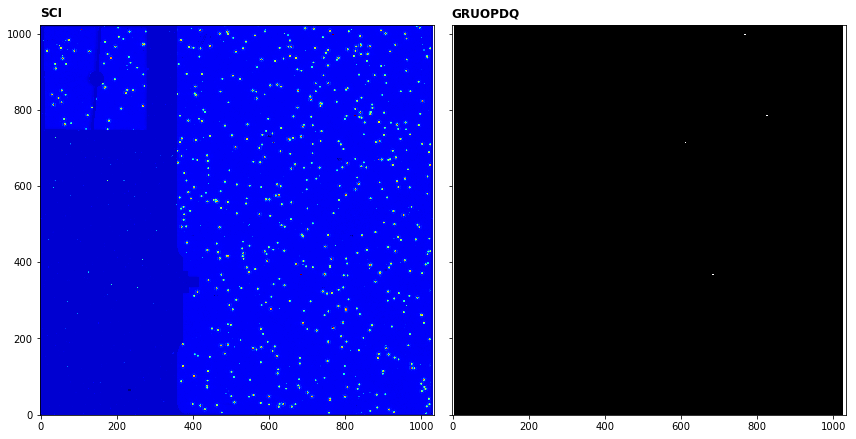

In [11]:
# plot--------------------------------------   
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# show last frame of first integration
axs[0].imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=5e4))
axs[0].annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

# plot last frame of first integration GROUP_DQ
axs[1].imshow(dm.groupdq[0,-1,:,:], cmap='gray', interpolation='nearest', origin='lower', vmin=0, vmax=1)
axs[1].annotate('GRUOPDQ', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()
    

## LINEARITY step ===============================================

This step corrects for detector non-linearity. The linearity coefficients are read from the linearity correction reference file.

http://ssb.stsci.edu/doc/jwst_dev/jwst/linearity/index.html


### LINEARITY: load module and show options

In [12]:
# import the step
from jwst.linearity import linearity_step

# print the description and options
print linearity_step.LinearityStep.__doc__
print linearity_step.LinearityStep.spec

# copy the datamodel for input/output comparison
in_dm = dm.copy()


    LinearityStep: This step performs a correction for non-linear
    detector response, using the "classic" polynomial method.
    

    pre_hooks = string_list(default=list())
    post_hooks = string_list(default=list())
    output_dir = string(default=None)       # Directory path for output files
    output_file = output_file(default=None) # File to save output to.
    skip = boolean(default=False)           # Skip this step
    save_results = boolean(default=False)   # Force save results
    suffix = string(default=None)           # Default suffix for output files
    


### LINEARITY: run step

In [13]:
# run the linearity step
dm = linearity_step.LinearityStep.call(dm, save_results=True, output_dir=output_dir, output_file='linearity_out.fits')

2017-08-30 11:33:35,263 - stpipe.LinearityStep - INFO - LinearityStep instance created.
2017-08-30 11:33:35,959 - stpipe.LinearityStep - INFO - Prefetch for LINEARITY reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_linearity_0024.fits'.
2017-08-30 11:33:36,024 - stpipe.LinearityStep - INFO - Step LinearityStep running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x193c0a250>,).
2017-08-30 11:33:36,508 - stpipe.LinearityStep - INFO - Using Linearity reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_linearity_0024.fits
2017-08-30 11:33:38,681 - stpipe.LinearityStep - INFO - Saving file IMA_demo_data_steps_output/linearity_out.fits
2017-08-30 11:33:40,384 - stpipe.LinearityStep - INFO - Step LinearityStep done


### LINEARITY:  plot output science image to select pixel for inspection

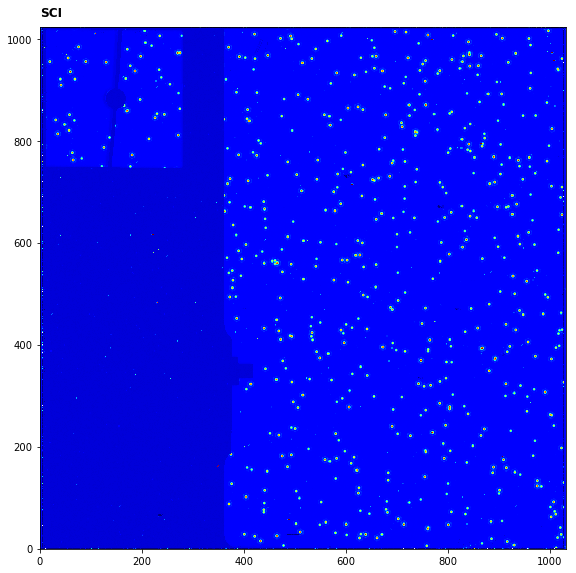

In [14]:
# plot--------------------------------------
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=8e3,vmax=5e4))
axs.annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()

### LINEARITY:  input/output ramp comparison

1. plot the input and output ramps

2. show the difference between these

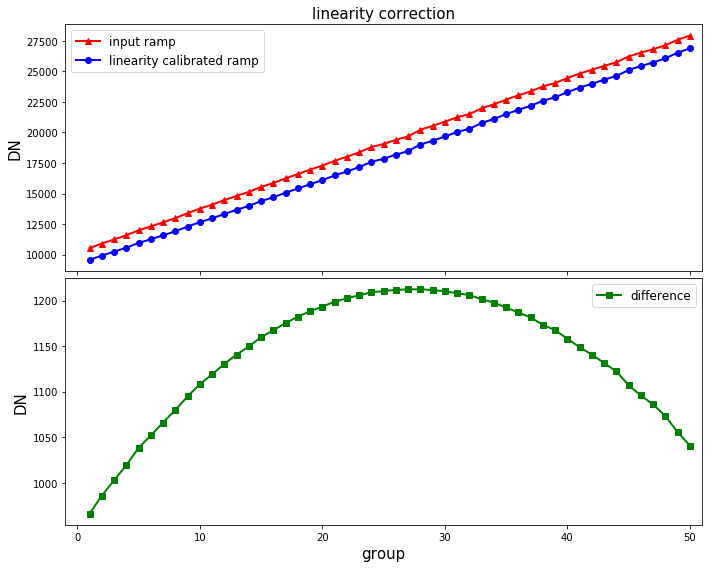

In [15]:
# using image in previous cell, select pixel to check
pixel = [703,488]

# define group numbers for integration ramps
group = range(1,in_dm.data[0,:,pixel[0],pixel[1]].shape[0]+1,1)

# plot--------------------------------------
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# plot input and output ramps of the first integration
axs[0].plot(group, in_dm.data[0,:,pixel[1],pixel[0]], c='r', marker='^', markersize=6, linestyle='-', linewidth=2, label='input ramp')
axs[0].plot(group, dm.data[0,:,pixel[1],pixel[0]], c='b', marker='o', linestyle='-', linewidth=2, label='linearity calibrated ramp')
axs[0].set_title('linearity correction',fontsize=15)
axs[0].set_ylabel('DN',fontsize=15)
axs[0].set_xlim(-1,max(group)+1)
axs[0].legend(prop={'size':12}, loc=0)

# plot difference
axs[1].plot(group, in_dm.data[0,:,pixel[1],pixel[0]] - dm.data[0,:,pixel[1],pixel[0]], c='g', marker='s', markersize=6, linestyle='-', linewidth=2, label='difference')
axs[1].set_ylabel('DN',fontsize=15)
axs[1].set_xlabel('group',fontsize=15)
axs[1].legend(prop={'size':12}, loc=0)

plt.tight_layout(h_pad=0)
plt.show()



## RSCD step ======================================================
This step corrects for the slow adjustment of the reset FET to the asymtotic level after reset. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/rscd/index.html


### RSCD: load module and show options

In [16]:
# import the step
from jwst.rscd import rscd_step

# print the description and options
print rscd_step.RSCD_Step.__doc__
print rscd_step.RSCD_Step.spec

# copy the datamodel for input/output comparison
in_dm = dm.copy()


    RSCD_Step: Performs an RSCD correction to MIRI data by adding a function
    of time, frame by frame, to a copy of the input science data model.
    

    pre_hooks = string_list(default=list())
    post_hooks = string_list(default=list())
    output_dir = string(default=None)       # Directory path for output files
    output_file = output_file(default=None) # File to save output to.
    skip = boolean(default=False)           # Skip this step
    save_results = boolean(default=False)   # Force save results
    suffix = string(default=None)           # Default suffix for output files
    


#### RSCD: run step

In [17]:
# run the rscd step
dm = rscd_step.RSCD_Step.call(dm, save_results=True, output_dir=output_dir, output_file='rscd_out.fits')

2017-08-30 11:33:42,573 - stpipe.RSCD_Step - INFO - RSCD_Step instance created.
2017-08-30 11:33:43,433 - stpipe.RSCD_Step - INFO - Prefetch for RSCD reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_rscd_0004.fits'.
2017-08-30 11:33:43,484 - stpipe.RSCD_Step - INFO - Step RSCD_Step running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x16d8eb210>,).
2017-08-30 11:33:44,039 - stpipe.RSCD_Step - INFO - Using RSCD reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_rscd_0004.fits
2017-08-30 11:34:22,481 - stpipe.RSCD_Step - INFO - Saving file IMA_demo_data_steps_output/rscd_out.fits
2017-08-30 11:34:24,298 - stpipe.RSCD_Step - INFO - Step RSCD_Step done


### RSCD:  plot output science image to select pixel for inspection

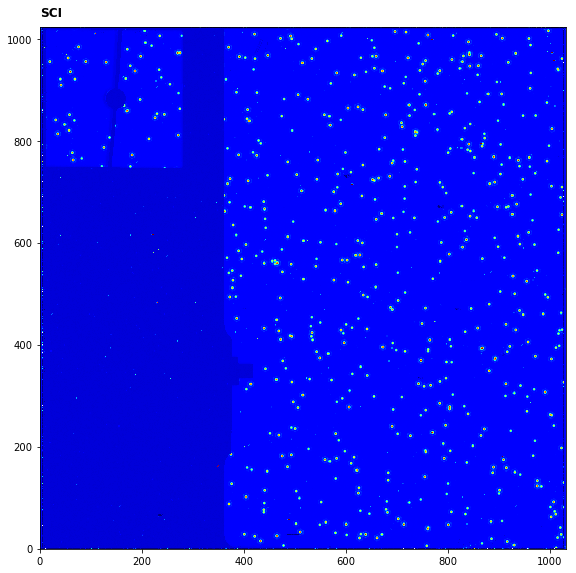

In [18]:
# plot--------------------------------------
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=8e3,vmax=5e4))
axs.annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()

### RSCD:  input/output ramp comparison

1. plot the input and output ramps. Note that the RSCD step only corrects following a reset show will note perform a correction if there is only one integration in the exposure.

2. show the difference between the input and output ramps


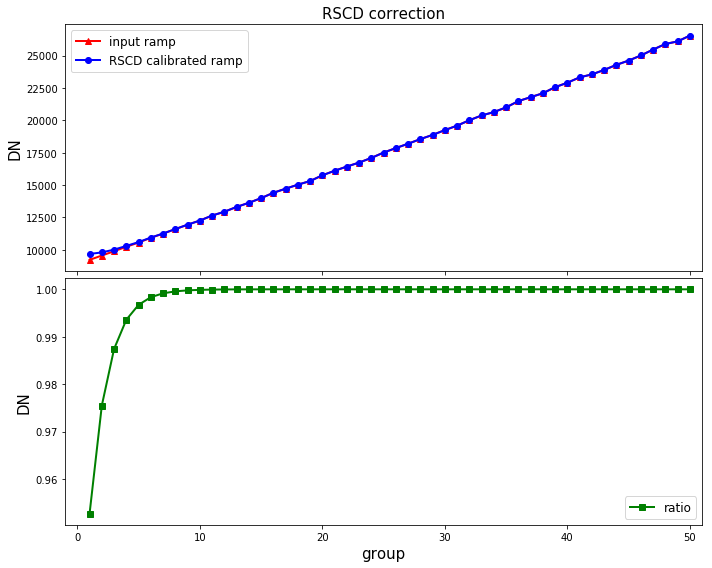

In [19]:
# using image in previous cell, select pixel to check, 
# comment out if you want to use pixel defined earlier
#pixel = [560,237]

   
# first check that there is more than one integration
if in_dm.data.shape[0] > 1:

    # plot--------------------------------------
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # plot input and output ramps of the second integration
    axs[0].plot(group, in_dm.data[-1,:,pixel[1],pixel[0]], c='r', marker='^', markersize=6, linestyle='-', linewidth=2, label='input ramp')
    axs[0].plot(group, dm.data[-1,:,pixel[1],pixel[0]], c='b', marker='o', linestyle='-', linewidth=2, label='RSCD calibrated ramp')
    axs[0].set_title('RSCD correction',fontsize=15)
    axs[0].set_ylabel('DN',fontsize=15)
    axs[0].set_xlim(-1,max(group)+1)
    axs[0].legend(prop={'size':12}, loc=0)

    # plot ratio between the two
    axs[1].plot(group, in_dm.data[-1,:,pixel[1],pixel[0]] / dm.data[-1,:,pixel[1],pixel[0]], c='g', marker='s', markersize=6, linestyle='-', linewidth=2, label='ratio')
    axs[1].set_ylabel('DN',fontsize=15)
    axs[1].set_xlabel('group',fontsize=15)
    axs[1].legend(prop={'size':12}, loc=0)

    plt.tight_layout(h_pad=0)
    plt.show()

else: print "RSCD step only operates on exposures with more than one integration."


## LASTFRAME step ==========================================
This step corrects for the anonolous offsets in the last frame of an integration due to the way MIRI detectors reset sequentially. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/rscd/index.html


### LASTFRAME: load module and show options

In [20]:
# import the step
from jwst.lastframe import lastframe_step

# print the description and options
print lastframe_step.LastFrameStep.__doc__
print lastframe_step.LastFrameStep.spec

# copy the datamodel for input/output comparison
in_dm = dm.copy()


    LastFrameStep: This is a MIRI specific task.  If the number of groups
    is greater than 1, the GROUP data quality flags for the final group will
    be set to DO_NOT_USE.
    

    pre_hooks = string_list(default=list())
    post_hooks = string_list(default=list())
    output_dir = string(default=None)       # Directory path for output files
    output_file = output_file(default=None) # File to save output to.
    skip = boolean(default=False)           # Skip this step
    save_results = boolean(default=False)   # Force save results
    suffix = string(default=None)           # Default suffix for output files
    


### LASTFRAME: run step

In [21]:
# run the lastframe step
dm = lastframe_step.LastFrameStep.call(dm, save_results=True, output_dir=output_dir, output_file='lastframe_out.fits')

2017-08-30 11:34:26,904 - stpipe.LastFrameStep - INFO - LastFrameStep instance created.
2017-08-30 11:34:27,241 - stpipe.LastFrameStep - INFO - Step LastFrameStep running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x104c39810>,).
2017-08-30 11:34:28,415 - stpipe.LastFrameStep - INFO - Saving file IMA_demo_data_steps_output/lastframe_out.fits
2017-08-30 11:34:30,321 - stpipe.LastFrameStep - INFO - Step LastFrameStep done


### LASTFRAME:  input/output ramp comparison

This correction flags the last frame of an integration so we can check that the last frame has indeed been flagged in the groupDQ extension.

1. plot the last frame of the first integration of the GROUPDQ extension, show values of flags (should be solid colour)

2. plot the input and output GROUPDQ to show that last frame has been flagged

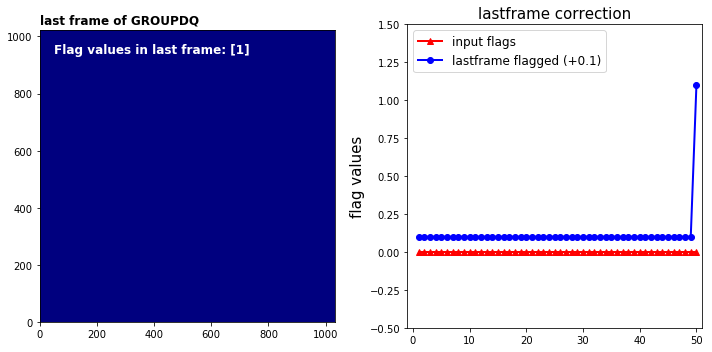

In [22]:
# define an input and output integration ramp for a given pixel
# using image in previous cell, select pixel to check, 
# comment out if you want to use pixel defined earlier
#pixel = [560,237]

# plot--------------------------------------
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# plot the last frame of the first integration of the GROUPDQ extension
axs[0].imshow(dm.groupdq[-1][-1], cmap='jet', interpolation='nearest', origin='lower')
axs[0].annotate('last frame of GROUPDQ', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

# determine the values in this GROUPDQ frame
flag_values = np.unique(dm.groupdq[-1][-1])
axs[0].annotate('Flag values in last frame: %s' % flag_values, xy=(0.05, 0.92), xycoords='axes fraction', fontsize=12, fontweight='bold', color='w')

# input and output ramps (setting a slight offset for the output ramp)
axs[1].plot(group, in_dm.groupdq[-1,:,pixel[1],pixel[0]], c='r', marker='^', markersize=6, linestyle='-', linewidth=2, label='input flags')
axs[1].plot(group, dm.groupdq[-1,:,pixel[1],pixel[0]]+0.1, c='b', marker='o', linestyle='-', linewidth=2, label='lastframe flagged (+0.1)')
axs[1].set_title('lastframe correction',fontsize=15)
axs[1].set_ylabel('flag values',fontsize=15)
axs[1].set_xlim(-1,max(group)+1)
axs[1].set_ylim(-0.5,1.5)
axs[1].legend(prop={'size':12}, loc=2)

plt.tight_layout(h_pad=0)
plt.show()



## DARK_CURRENT step ==========================================

This step removes the dark current by subtracting a dark current reference file.

http://ssb.stsci.edu/doc/jwst_dev/jwst/dark_current/index.html

Note that since a dark_current was not included in the MIRISim simulations that produced the demo data, we will skip the dark_current step.

### DARK_CURRENT: load module and show options

In [23]:
# import the step
from jwst.dark_current import dark_current_step

# print the description and options
print dark_current_step.DarkCurrentStep.__doc__
print dark_current_step.DarkCurrentStep.spec

# copy the datamodel for input/output comparison
in_dm = dm.copy()


    DarkCurrentStep: Performs dark current correction by subtracting
    dark current reference data from the input science data model.
    

        dark_output = output_file(default = None) # Dark model or averaged dark subtracted
    


### DARK_CURRENT: run step

In [24]:
# run the dark_current step
dm = dark_current_step.DarkCurrentStep.call(dm, save_results=True, output_dir=output_dir, output_file='dark_current_out.fits', skip=True)

2017-08-30 11:34:32,368 - stpipe.DarkCurrentStep - INFO - DarkCurrentStep instance created.
2017-08-30 11:34:32,815 - stpipe.DarkCurrentStep - INFO - Step DarkCurrentStep running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x16dcf8910>,).
2017-08-30 11:34:32,816 - stpipe.DarkCurrentStep - INFO - Step skipped.
2017-08-30 11:34:32,824 - stpipe.DarkCurrentStep - INFO - Step DarkCurrentStep done


### DARK_CURRENT:  plot output science image to select pixel for inspection

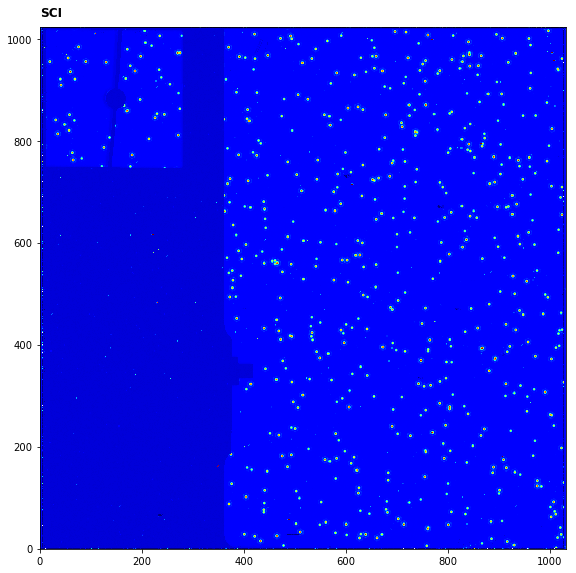

In [25]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=8e3,vmax=5e4))
axs.annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()

### DARK_CURRENT:  input/output ramp comparison

1. plot the input and output ramps

2. show the difference between these


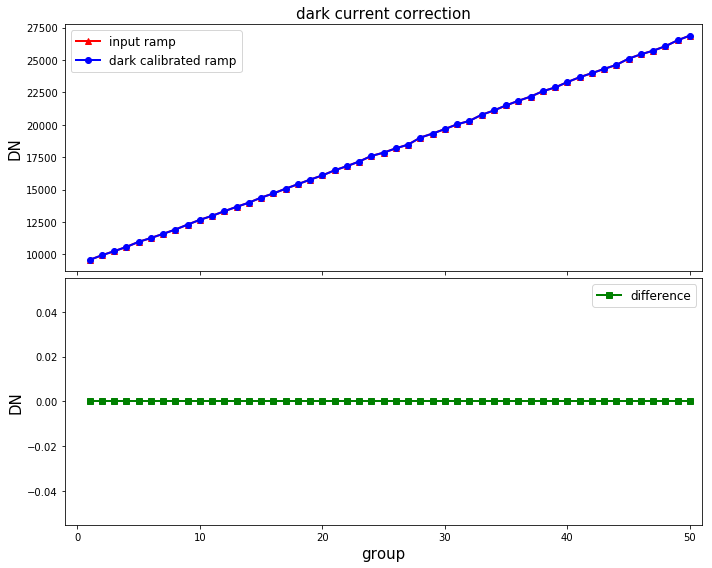

In [26]:
# using image in previous cell, select pixel to check, 
# comment out if you want to use pixel defined earlier
#pixel = [560,237]

# plot--------------------------------------
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# plot input and output ramps of the second integration
axs[0].plot(group, in_dm.data[0,:,pixel[1],pixel[0]], c='r', marker='^', markersize=6, linestyle='-', linewidth=2, label='input ramp')
axs[0].plot(group, dm.data[0,:,pixel[1],pixel[0]], c='b', marker='o', linestyle='-', linewidth=2, label='dark calibrated ramp')
axs[0].set_title('dark current correction',fontsize=15)
axs[0].set_ylabel('DN',fontsize=15)
axs[0].set_xlim(-1,max(group)+1)
axs[0].legend(prop={'size':12}, loc=0)

# plot difference between the two
axs[1].plot(group, in_dm.data[0,:,pixel[1],pixel[0]] - dm.data[0,:,pixel[1],pixel[0]], c='g', marker='s', markersize=6, linestyle='-', linewidth=2, label='difference')
axs[1].set_ylabel('DN',fontsize=15)
axs[1].set_xlabel('group',fontsize=15)
axs[1].legend(prop={'size':12}, loc=0)

plt.tight_layout(h_pad=0)
plt.show()

## REFPIX step =============================================
This step corrects for electronic drift effects in the data by applying the reference pixel correction. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/refpix/index.html


### REFPIX: load module and show options

In [27]:
# import the step
from jwst.refpix import refpix_step

# print the description and options
print refpix_step.RefPixStep.__doc__
print refpix_step.RefPixStep.spec

# copy the datamodel for input/output comparison
in_dm = dm.copy()



    RefPixStep: Use reference pixels to correct bias drifts

    

        odd_even_columns = boolean(default=True)
        use_side_ref_pixels = boolean(default=True)
        side_smoothing_length = integer(default=11)
        side_gain = float(default=1.0)
        odd_even_rows = boolean(default=True)
    


### REFPIX: run step

In [28]:
# run the refpix step
dm = refpix_step.RefPixStep.call(dm, save_results=True, output_dir=output_dir, output_file='refpix_out.fits')

2017-08-30 11:34:34,887 - stpipe.RefPixStep - INFO - RefPixStep instance created.
2017-08-30 11:34:35,585 - stpipe.RefPixStep - INFO - Prefetch for REFPIX reference file is 'N/A'.
2017-08-30 11:34:35,653 - stpipe.RefPixStep - INFO - Step RefPixStep running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x16dcf8910>,).
2017-08-30 11:34:35,785 - stpipe.RefPixStep - INFO - use_side_ref_pixels = True
2017-08-30 11:34:35,786 - stpipe.RefPixStep - INFO - odd_even_columns = True
2017-08-30 11:34:35,787 - stpipe.RefPixStep - INFO - side_smoothing_length = 11
2017-08-30 11:34:35,788 - stpipe.RefPixStep - INFO - side_gain = 1.000000
2017-08-30 11:34:35,789 - stpipe.RefPixStep - INFO - odd_even_rows = True
2017-08-30 11:34:35,790 - stpipe.RefPixStep - INFO - Subtracting initial read from each integration
2017-08-30 11:34:37,133 - stpipe.RefPixStep - INFO - Adding initial read back in
2017-08-30 11:34:39,000 - stpipe.RefPixStep - INFO - Saving file IMA_demo_data_steps_output/refpix_

### REFPIX:  plot output science image to select pixel for inspection

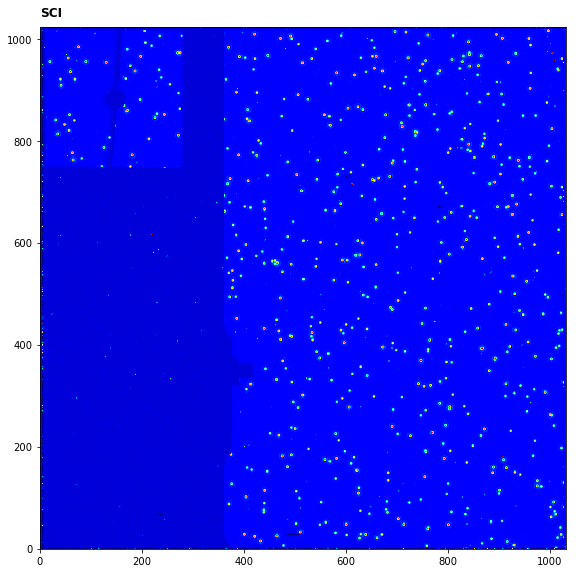

In [29]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=8e3,vmax=5e4))
axs.annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()

### REFPIX:  input/output ramp comparison

1. plot the input and output ramps

2. show the difference between these


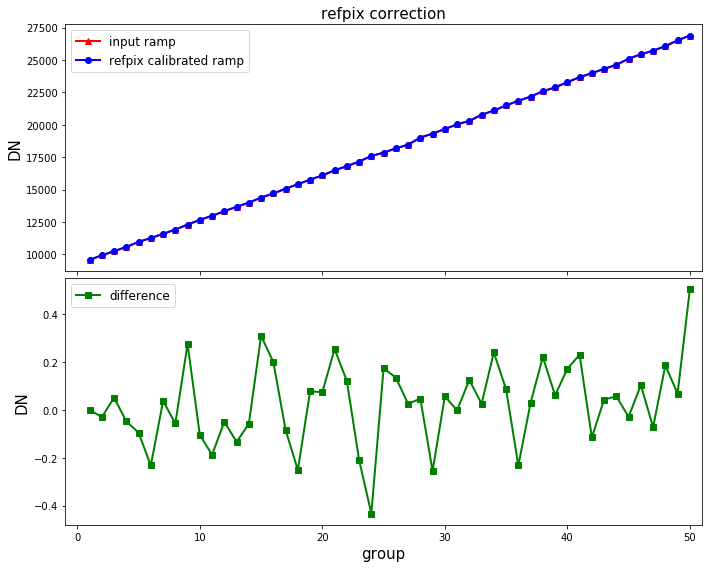

In [30]:
# using image in previous cell, select pixel to check, 
# comment out if you want to use pixel defined earlier
#pixel = [560,237]


# plot--------------------------------------
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# plot input and output ramps of the second integration
axs[0].plot(group, in_dm.data[0,:,pixel[1],pixel[0]], c='r', marker='^', markersize=6, linestyle='-', linewidth=2, label='input ramp')
axs[0].plot(group, dm.data[0,:,pixel[1],pixel[0]], c='b', marker='o', linestyle='-', linewidth=2, label='refpix calibrated ramp')
axs[0].set_title('refpix correction',fontsize=15)
axs[0].set_ylabel('DN',fontsize=15)
axs[0].set_xlim(-1,max(group)+1)
axs[0].legend(prop={'size':12}, loc=0)

# plot difference between the two
axs[1].plot(group, in_dm.data[0,:,pixel[1],pixel[0]] - dm.data[0,:,pixel[1],pixel[0]], c='g', marker='s', markersize=6, linestyle='-', linewidth=2, label='difference')
axs[1].set_ylabel('DN',fontsize=15)
axs[1].set_xlabel('group',fontsize=15)
axs[1].legend(prop={'size':12}, loc=0)

plt.tight_layout(h_pad=0)
plt.show()

## JUMP correction =================================================

This step detects jumps in the ramp by looking for outliers from the ramp. It updates the GROUPDQ array to indicate where a jump was found.

http://ssb.stsci.edu/doc/jwst_dev/jwst/jump/index.html


### JUMP: load module and show options

In [31]:
# import the step
from jwst.jump import jump_step

# print the description and options
print jump_step.JumpStep.__doc__
print jump_step.JumpStep.spec

# copy the datamodel for input/output comparison
in_dm = dm.copy()


    JumpStep: Performs CR/jump detection on each ramp integration within an
    exposure. The 2-point difference method is applied.
    

        rejection_threshold = float(default=4.0,min=0) # CR rejection threshold
    


### JUMP: run step

In [32]:
# run the jump step
dm = jump_step.JumpStep.call(dm, save_results=True, output_dir=output_dir, output_file='jump_out.fits')

2017-08-30 11:34:42,821 - stpipe.JumpStep - INFO - JumpStep instance created.
2017-08-30 11:34:43,465 - stpipe.JumpStep - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits'.
2017-08-30 11:34:43,466 - stpipe.JumpStep - INFO - Prefetch for READNOISE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0040.fits'.
2017-08-30 11:34:43,532 - stpipe.JumpStep - INFO - Step JumpStep running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x16cf4cc10>,).
2017-08-30 11:34:43,666 - stpipe.JumpStep - INFO - CR rejection threshold = 4 sigma
2017-08-30 11:34:44,018 - stpipe.JumpStep - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits
2017-08-30 11:34:44,410 - stpipe.JumpStep - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0040.fits
2017-08

### JUMP:  plot output science image to select pixel for inspection

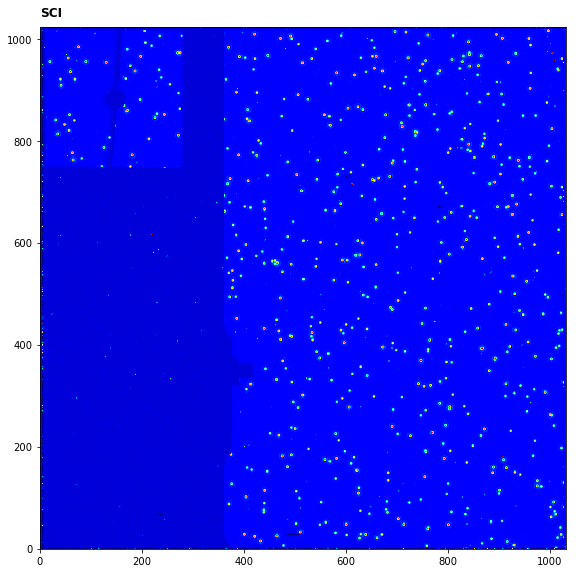

In [33]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=8e3,vmax=5e4))
axs.annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()

### JUMP:  input/output ramp comparison

1. plot the output ramp

2. show the input and output GROUPDQ vectors and mark where jumps were detected (a flag of >=4 in GROUPDQ)


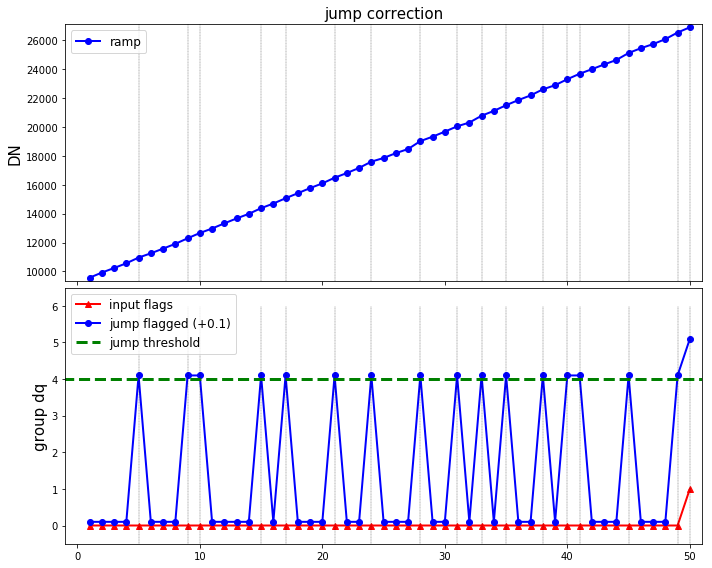

In [34]:
# using image in previous cell, select pixel to check, 
# comment out if you want to use pixel defined earlier
#pixel = [560,237]

# plot--------------------------------------
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# first integration for input/output ramps
axs[0].plot(group, dm.data[0,:,pixel[1],pixel[0]], c='b', marker='o', linestyle='-', linewidth=2, label='ramp')
axs[0].set_title('jump correction',fontsize=15)
axs[0].set_ylabel('DN',fontsize=15)
axs[0].set_xlim(-1,max(group)+1)
axs[0].set_ylim(min(dm.data[0,:,pixel[1],pixel[0]])-200,max(dm.data[0,:,pixel[1],pixel[0]])+200)
axs[0].legend(prop={'size':12}, loc=2)

# input and output flag values (setting a slight offset for the output flags)
axs[1].plot(group, in_dm.groupdq[0,:,pixel[1],pixel[0]], c='r', marker='^', markersize=6, linestyle='-', linewidth=2, label='input flags')
axs[1].plot(group, dm.groupdq[0,:,pixel[1],pixel[0]]+0.1, c='b', marker='o', linestyle='-', linewidth=2, label='jump flagged (+0.1)')
axs[1].plot([-10,100],[4,4], linestyle='--', linewidth=3, c='g', label='jump threshold')
axs[1].set_ylabel('flag values',fontsize=15)
axs[1].set_ylabel('group dq',fontsize=15)
axs[1].set_xlim(-1,max(group)+1)
axs[1].set_ylim(-0.5,6.5)
axs[1].legend(prop={'size':12}, loc=2)

# draw lines to show the groups which have been flagged as jumps
for n, val in enumerate(group):
    if (dm.groupdq[0,n,pixel[1],pixel[0]] >= 4): 
        axs[0].plot([n+1,n+1],[min(dm.data[0,:,pixel[1],pixel[0]])-200,max(dm.data[0,:,pixel[1],pixel[0]])+200], linestyle='--', linewidth=0.3, c='k')
        axs[1].plot([n+1,n+1],[-1,6], linestyle='--', linewidth=0.3, c='k')

plt.tight_layout(h_pad=0)
plt.show()


## RAMP_FITTING step =========================================

This step caculates the mean count rate for each pixel by performing a linear fit to the ramps. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/ramp_fitting/index.html

There are two outputs are here:

1) the slope image  (normally ending in _rate.fits)

2) if more than one integration, slope image per integration  (normally ending in _rateints.fits)

This is the last step in the level 2A pipeline.


### RAMP_FITTING: load module and show options

In [35]:
# import the step
from jwst.ramp_fitting import ramp_fit_step

# print the description and options
print ramp_fit_step.RampFitStep.__doc__
print ramp_fit_step.RampFitStep.spec



    This step fits a straight line to the value of counts vs. time to
    determine the mean count rate for each pixel.
    

        int_name = string(default='')
        save_opt = boolean(default=False) # Save optional output
        opt_name = string(default='')

    


### RAMP_FITTING: run step

In [36]:
# run the ramp_fitting step
dm = ramp_fit_step.RampFitStep.call(dm, save_results=True, output_dir=output_dir, 
                                    output_file='ramp_fit_out.fits', int_name='ramp_fit_int_out.fits')

# copy datamodel for comparison later
level2A_dm = dm.copy()

2017-08-30 11:36:40,679 - stpipe.RampFitStep - INFO - RampFitStep instance created.
2017-08-30 11:36:41,531 - stpipe.RampFitStep - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits'.
2017-08-30 11:36:41,532 - stpipe.RampFitStep - INFO - Prefetch for READNOISE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0040.fits'.
2017-08-30 11:36:41,600 - stpipe.RampFitStep - INFO - Step RampFitStep running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x16fe4ec90>,).
2017-08-30 11:36:42,520 - stpipe.RampFitStep - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0040.fits
2017-08-30 11:36:42,560 - stpipe.RampFitStep - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits
2017-08-30 11:36:42,595 - stpipe.RampFitStep - INFO - Using algorit

### RAMP_FITTING:  level 1B and level 2A image comparison

Visually compare the input ramp and the output slope image

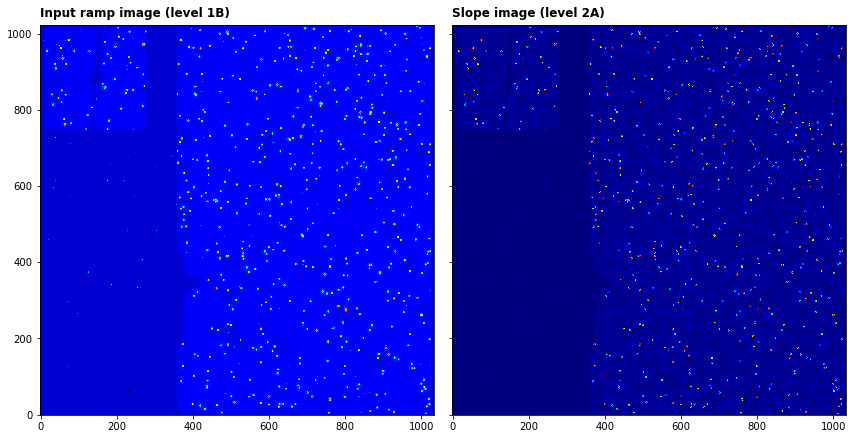

In [37]:
# open the level 1B input as a jwst data model
with datamodels.open(input_files[0]) as in_dm:

    # plot--------------------------------------
    # show the input ramp image and the calibrated
    # slope image.
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

    # sum the groups in the first integration of the input ramp image and plot
    axs[0].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=5e4))
    axs[0].annotate('Input ramp image (level 1B)', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
    axs[0].set_facecolor('black')
    axs[1].imshow(dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=1, vmax=100)
    axs[1].annotate('Slope image (level 2A)', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
    axs[1].set_facecolor('black')

plt.tight_layout()
plt.show()
    

## ASSIGN_WCS step =================================================
This step creates a WCS object and associates it with the science file, mapping detector to world coordinates. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/assign_wcs/index.html


In [38]:
# import the step
from jwst.assign_wcs import assign_wcs_step

# print the description and options
print assign_wcs_step.AssignWcsStep.__doc__
print assign_wcs_step.AssignWcsStep.spec



    AssignWcsStep: Loads all WCS and distortion information for an exposure
    and stores it in the model meta data.
    

    


### ASSIGN_WCS: run step

In [39]:
# run the assign_wcs step
dm = assign_wcs_step.AssignWcsStep.call(dm, save_results=True, output_dir=output_dir, output_file='assign_wcs_out.fits')

2017-08-30 11:42:46,180 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2017-08-30 11:42:47,069 - stpipe.AssignWcsStep - INFO - Prefetch for CAMERA reference file is 'N/A'.
2017-08-30 11:42:47,072 - stpipe.AssignWcsStep - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2017-08-30 11:42:47,073 - stpipe.AssignWcsStep - INFO - Prefetch for DISPERSER reference file is 'N/A'.
2017-08-30 11:42:47,075 - stpipe.AssignWcsStep - INFO - Prefetch for DISTORTION reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_distortion_0023.asdf'.
2017-08-30 11:42:47,077 - stpipe.AssignWcsStep - INFO - Prefetch for FILTEROFFSET reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_filteroffset_0003.asdf'.
2017-08-30 11:42:47,079 - stpipe.AssignWcsStep - INFO - Prefetch for FORE reference file is 'N/A'.
2017-08-30 11:42:47,080 - stpipe.AssignWcsStep - INFO - Prefetch for FPA reference file is 'N/A'.
2017-08-30 11:42:47,081 -

2017-08-30 11:42:55,162 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


### ASSIGN_WCS:  plot output science image to select pixel for inspection

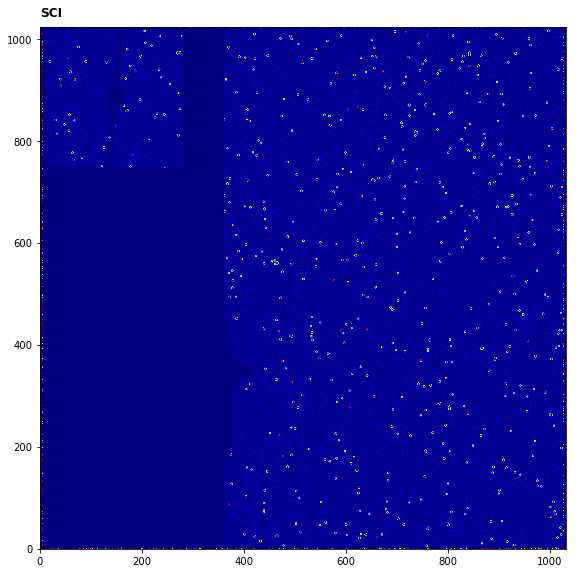

In [40]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=1, vmax=100)
axs.annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()

### ASSIGN_WCS: perform some transforms

1. Display the available coordinate frames

2. perform some transfer from pixel to WCS

In [41]:
# using image in previous cell, select pixel to check, 
# comment out if you want to use pixel defined earlier
#pixel = [560,237]

# print available coordinate frames
print "Available coordinate frames:" 
print(", ".join(dm.meta.wcs.available_frames))
print ""

# perform transforms on pixel
ra, dec = dm.meta.wcs(pixel[0],pixel[1])

print "Pixel: %d, %d" % (pixel[0],pixel[1])
print "assign_wcs RA, DEC (deg): %0.7f %0.7f" % (ra,dec)


Available coordinate frames:
detector, v2v3, world

Pixel: 703, 488
assign_wcs RA, DEC (deg): -0.0000022 -0.0018308


## FLAT_FIELD step =============================================
The flat_field step divides the image by a flat-field reference image and updates the DQ array to indicate where no flat-field is available for a pixel. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/flatfield/index.html


### FLAT_FIELD: load module and show options

In [42]:
# import the step
from jwst.flatfield import flat_field_step

# print the description and options
print flat_field_step.FlatFieldStep.__doc__
print flat_field_step.FlatFieldStep.spec

# copy the datamodel for input/output comparison
in_dm = dm.copy()


    FlatFieldStep: Flat-field a science image using a flatfield reference image.
    

        # Suffix for optional output file for interpolated flat fields.
        # Note that this is only used for NIRSpec spectrographic data.
        flat_suffix = string(default=None)
    


### FLAT_FIELD: run step

In [43]:
# run the flat_field step
dm = flat_field_step.FlatFieldStep.call(dm, save_results=True, output_dir=output_dir, output_file='flatfield_out.fits')

2017-08-30 11:42:55,982 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.
2017-08-30 11:42:56,856 - stpipe.FlatFieldStep - INFO - Prefetch for DFLAT reference file is 'N/A'.
2017-08-30 11:42:56,857 - stpipe.FlatFieldStep - INFO - Prefetch for FFLAT reference file is 'N/A'.
2017-08-30 11:42:56,858 - stpipe.FlatFieldStep - INFO - Prefetch for FLAT reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_flat_0123.fits'.
2017-08-30 11:42:56,859 - stpipe.FlatFieldStep - INFO - Prefetch for SFLAT reference file is 'N/A'.
2017-08-30 11:42:56,941 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args (<jwst.datamodels.image.ImageModel object at 0x16d92ed50>,).
2017-08-30 11:42:57,692 - stpipe.FlatFieldStep - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored
2017-08-30 11:42:57,694 - stpipe.FlatFieldStep - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so 

### FLAT_FIELD: input/output image checks

1. Display the input and output images
2. Show the ratio of the two

2017-08-30 11:42:58,730 - stpipe - WARNING - /Users/patrickkavanagh/anaconda/envs/jwstb7.1rc2/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app



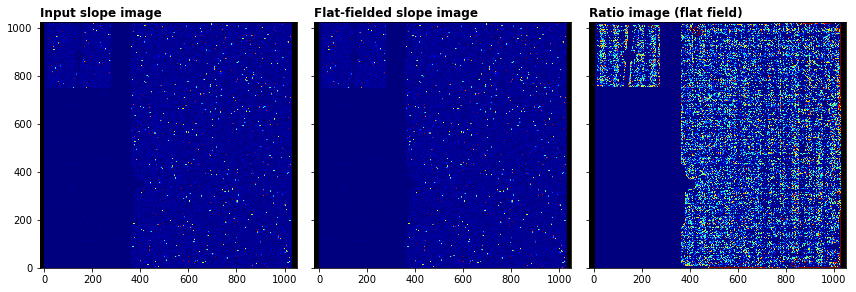

In [44]:
# plot--------------------------------------
# show the input, output and ratio image, 
# which will correspond to the flat field.
fig, axs = plt.subplots(1, 3, figsize=(12, 4),sharey=True)

# show the input
axs[0].imshow(in_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=1, vmax=100)
axs[0].annotate('Input slope image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[0].set_facecolor('black')

axs[1].imshow(dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=1, vmax=100)
axs[1].annotate('Flat-fielded slope image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[1].set_facecolor('black')

axs[2].imshow(in_dm.data / dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=1.00, vmax=1.01)
axs[2].annotate('Ratio image (flat field)', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[2].set_facecolor('black')

plt.tight_layout()
plt.show()

## PHOTOM step =======================================
This step uses spectroscopic photometric conversion reference files to convert count rates to absolute flux units. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/photom/index.html

This is the last step in the level 2b pipeline.

### PHOTOM: load module and show options

In [45]:
# import the step
from jwst.photom import photom_step

# print the description and options
print photom_step.PhotomStep.__doc__
print photom_step.PhotomStep.spec



    PhotomStep: Module for loading photometric conversion infomation from
        reference files and attaching or applying them to the input science
        data model
    

    pre_hooks = string_list(default=list())
    post_hooks = string_list(default=list())
    output_dir = string(default=None)       # Directory path for output files
    output_file = output_file(default=None) # File to save output to.
    skip = boolean(default=False)           # Skip this step
    save_results = boolean(default=False)   # Force save results
    suffix = string(default=None)           # Default suffix for output files
    


### PHOTOM: run step

In [46]:
dm = photom_step.PhotomStep.call(dm, save_results=True, output_dir=output_dir, output_file='photom_out.fits')

2017-08-30 11:42:59,280 - stpipe.PhotomStep - INFO - PhotomStep instance created.
2017-08-30 11:43:00,100 - stpipe.PhotomStep - INFO - Prefetch for AREA reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_area_0003.fits'.
2017-08-30 11:43:00,101 - stpipe.PhotomStep - INFO - Prefetch for PHOTOM reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_photom_0014.fits'.
2017-08-30 11:43:00,202 - stpipe.PhotomStep - INFO - Step PhotomStep running with args (<jwst.datamodels.image.ImageModel object at 0x16db1bc50>,).
2017-08-30 11:43:00,879 - stpipe.PhotomStep - INFO - Using photom reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_photom_0014.fits
2017-08-30 11:43:01,331 - stpipe.PhotomStep - INFO - Using area reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_area_0003.fits
2017-08-30 11:43:01,333 - stpipe.PhotomStep - INFO - Using instrument: MIRI
2017-08-30 11:43:0

### PHOTOM: check the correct photometric keywords in output header

1. Get the photometric information from the output header

In [47]:
print "Photometric conversions (Flux density producing 1 cps)"
print "%0.2e microJy/arcsec^2" % dm.meta.photometry.conversion_microjanskys
print "%0.2e MJy/sr" % dm.meta.photometry.conversion_megajanskys


Photometric conversions (Flux density producing 1 cps)
5.76e+01 microJy/arcsec^2
2.45e+00 MJy/sr


### PIPELINE OUTPUT CHECKS =======================================

The level 2B file is the calibrated slope product. We can show the evolution of the data through 1B - 2A - 2B stages

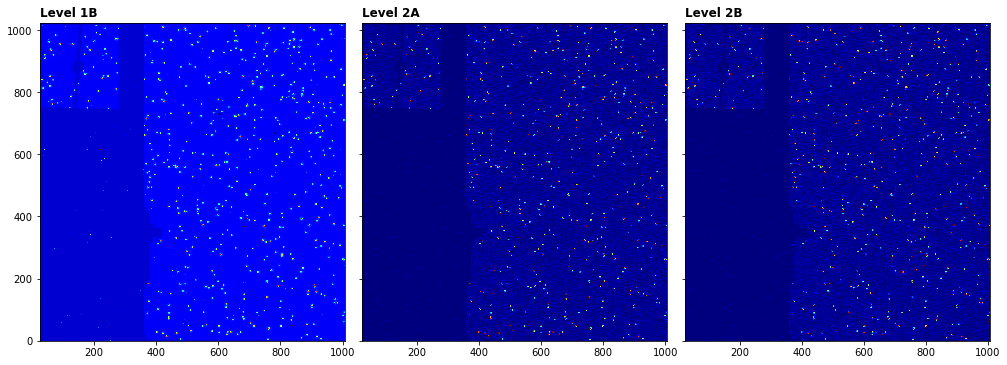

In [48]:
# open the input and output image as jwst data models
with datamodels.open(input_files[0]) as lvl1b_dm:

    # plot--------------------------------------
    # show the input ramp image and the calibrated
    # slope image.
    fig, axs = plt.subplots(1, 3, figsize=(14, 5), sharey=True)

    # 1B image
    axs[0].imshow(lvl1b_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=5e4))
    axs[0].annotate('Level 1B', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
    axs[0].set_facecolor('black')

    # 2A image
    axs[1].imshow(level2A_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=1, vmax=100)
    axs[1].annotate('Level 2A', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
    axs[1].set_facecolor('black')

    # 2B image
    axs[2].imshow(dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=1, vmax=100)
    axs[2].annotate('Level 2B', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
    axs[2].set_facecolor('black')

    plt.tight_layout()
    plt.show()

### BRING DITHERS TO LEVEL 2B FOR LEVEL 3 PROCESSING

We now bring the dithers to level 2B for use in the level 3 pipeline steps.

We must also create an association file containing the list of level 2B files ('_cal.fits') produced by the level 2B pipeline and load it into a model container. We can then process the dithers in the level 3 pipeline steps. 

In [49]:
from jwst.pipeline import SloperPipeline
from jwst.pipeline import Image2Pipeline

for f in input_files:
    dm = datamodels.open(f)
    dm = SloperPipeline.call(dm, save_results=True, steps={'dark_current':{'skip':True}})
    dm = Image2Pipeline.call(dm, save_results=True)

# create association file
level2B_files = glob.glob(os.path.join('*_cal.fits'))
call(["asn_from_list", "-o", "IMA_asn.json"] + level2B_files + ["--product-name", "ima_dither"])
dms = datamodels.ModelContainer("IMA_asn.json")


2017-08-30 11:43:06,196 - stpipe.SloperPipeline - INFO - SloperPipeline instance created.
2017-08-30 11:43:06,199 - stpipe.SloperPipeline.group_scale - INFO - GroupScaleStep instance created.
2017-08-30 11:43:06,201 - stpipe.SloperPipeline.saturation - INFO - SaturationStep instance created.
2017-08-30 11:43:06,203 - stpipe.SloperPipeline.rscd - INFO - RSCD_Step instance created.
2017-08-30 11:43:06,206 - stpipe.SloperPipeline.ipc - INFO - IPCStep instance created.
2017-08-30 11:43:06,208 - stpipe.SloperPipeline.ramp_fit - INFO - RampFitStep instance created.
2017-08-30 11:43:06,210 - stpipe.SloperPipeline.linearity - INFO - LinearityStep instance created.
2017-08-30 11:43:06,213 - stpipe.SloperPipeline.jump - INFO - JumpStep instance created.
2017-08-30 11:43:06,215 - stpipe.SloperPipeline.refpix - INFO - RefPixStep instance created.
2017-08-30 11:43:06,217 - stpipe.SloperPipeline.lastframe - INFO - LastFrameStep instance created.
2017-08-30 11:43:06,219 - stpipe.SloperPipeline.dq_ini

2017-08-30 11:44:18,776 - stpipe.SloperPipeline.jump - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0040.fits
2017-08-30 11:44:20,218 - stpipe.SloperPipeline.jump - INFO - Executing two-point difference method
2017-08-30 11:45:48,777 - stpipe.SloperPipeline.jump - INFO - Step jump done
2017-08-30 11:45:49,662 - stpipe.SloperPipeline.ramp_fit - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits'.
2017-08-30 11:45:49,663 - stpipe.SloperPipeline.ramp_fit - INFO - Prefetch for READNOISE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0040.fits'.
2017-08-30 11:45:49,762 - stpipe.SloperPipeline.ramp_fit - INFO - Step ramp_fit running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x11301e6d0>,).
2017-08-30 11:45:50,825 - stpipe.SloperPipeline.ramp_fit - INFO - Using READNOISE reference fil

2017-08-30 11:52:01,982 - stpipe.Image2Pipeline.photom - INFO - Writing PHOTMJSR with value: 2.44947
2017-08-30 11:52:02,098 - stpipe.Image2Pipeline.photom - INFO - Step photom done
2017-08-30 11:52:02,100 - stpipe.Image2Pipeline - INFO - Finished processing product det_image_1_MIRIMAGE_F1130Wexp1_rate
2017-08-30 11:52:02,102 - stpipe.Image2Pipeline - INFO - Step.save_model det_image_1_MIRIMAGE_F1130Wexp1_cal.fits
2017-08-30 11:52:02,853 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2
2017-08-30 11:52:02,855 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done
2017-08-30 11:52:06,350 - stpipe.SloperPipeline - INFO - SloperPipeline instance created.
2017-08-30 11:52:06,353 - stpipe.SloperPipeline.group_scale - INFO - GroupScaleStep instance created.
2017-08-30 11:52:06,355 - stpipe.SloperPipeline.saturation - INFO - SaturationStep instance created.
2017-08-30 11:52:06,357 - stpipe.SloperPipeline.rscd - INFO - RSCD_Step instance created.
2017-08-30 11:52:06,360 - stpipe.S

2017-08-30 11:53:32,454 - stpipe.SloperPipeline.jump - INFO - Prefetch for READNOISE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0040.fits'.
2017-08-30 11:53:32,566 - stpipe.SloperPipeline.jump - INFO - Step jump running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x16f209b10>,).
2017-08-30 11:53:32,732 - stpipe.SloperPipeline.jump - INFO - CR rejection threshold = 4 sigma
2017-08-30 11:53:33,239 - stpipe.SloperPipeline.jump - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits
2017-08-30 11:53:33,783 - stpipe.SloperPipeline.jump - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0040.fits
2017-08-30 11:53:35,421 - stpipe.SloperPipeline.jump - INFO - Executing two-point difference method
2017-08-30 11:55:06,106 - stpipe.SloperPipeline.jump - INFO - Step jump done
2017-08-30 11:55:07,042 - st

2017-08-30 12:00:52,285 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI
2017-08-30 12:00:52,286 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE
2017-08-30 12:00:52,287 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE
2017-08-30 12:00:52,288 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W
2017-08-30 12:00:52,342 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL
2017-08-30 12:00:52,412 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.
2017-08-30 12:00:52,414 - stpipe.Image2Pipeline.photom - INFO - Writing PHOTMJSR with value: 2.44947
2017-08-30 12:00:52,499 - stpipe.Image2Pipeline.photom - INFO - Step photom done
2017-08-30 12:00:52,500 - stpipe.Image2Pipeline - INFO - Finished processing product det_image_2_MIRIMAGE_F1130Wexp1_rate
2017-08-30 12:00:52,501 - stpipe.Image2Pipeline - INFO - Step.save_model det_image_2_MIRIMAGE_F1130Wexp1_cal.fits
2017-08-30 12:00:52,972 - stpipe.Image2Pipeline - INFO - ... ending c

2017-08-30 12:02:04,415 - stpipe.SloperPipeline.persistence - WARNING - Missing reference file types:  PERSAT TRAPDENSITY TRAPPARS
2017-08-30 12:02:04,427 - stpipe.SloperPipeline.persistence - INFO - Step persistence done
2017-08-30 12:02:05,278 - stpipe.SloperPipeline.jump - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits'.
2017-08-30 12:02:05,279 - stpipe.SloperPipeline.jump - INFO - Prefetch for READNOISE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0040.fits'.
2017-08-30 12:02:05,366 - stpipe.SloperPipeline.jump - INFO - Step jump running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x115a399d0>,).
2017-08-30 12:02:05,525 - stpipe.SloperPipeline.jump - INFO - CR rejection threshold = 4 sigma
2017-08-30 12:02:05,995 - stpipe.SloperPipeline.jump - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_m

2017-08-30 12:08:49,891 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<jwst.datamodels.image.ImageModel object at 0x1156201d0>,).
2017-08-30 12:08:50,541 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_photom_0014.fits
2017-08-30 12:08:51,018 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_area_0003.fits
2017-08-30 12:08:51,019 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI
2017-08-30 12:08:51,020 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE
2017-08-30 12:08:51,021 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE
2017-08-30 12:08:51,022 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W
2017-08-30 12:08:51,084 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL
2017-08-30 12:08:51,163 - stpipe.Image2Pipeline.photom - INFO - Pixel area map co

2017-08-30 12:10:01,867 - stpipe.SloperPipeline.refpix - INFO - Step refpix done
2017-08-30 12:10:02,784 - stpipe.SloperPipeline.persistence - INFO - Prefetch for PERSAT reference file is 'N/A'.
2017-08-30 12:10:02,785 - stpipe.SloperPipeline.persistence - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2017-08-30 12:10:02,787 - stpipe.SloperPipeline.persistence - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2017-08-30 12:10:02,895 - stpipe.SloperPipeline.persistence - INFO - Step persistence running with args (<jwst.datamodels.miri_ramp.MIRIRampModel object at 0x1157eb350>,).
2017-08-30 12:10:05,708 - stpipe.SloperPipeline.persistence - WARNING - Missing reference file types:  PERSAT TRAPDENSITY TRAPPARS
2017-08-30 12:10:05,720 - stpipe.SloperPipeline.persistence - INFO - Step persistence done
2017-08-30 12:10:06,661 - stpipe.SloperPipeline.jump - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.f

2017-08-30 12:16:46,626 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored
2017-08-30 12:16:47,055 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done
2017-08-30 12:16:48,029 - stpipe.Image2Pipeline.photom - INFO - Prefetch for AREA reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_area_0003.fits'.
2017-08-30 12:16:48,031 - stpipe.Image2Pipeline.photom - INFO - Prefetch for PHOTOM reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_photom_0014.fits'.
2017-08-30 12:16:48,190 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<jwst.datamodels.image.ImageModel object at 0x1154105d0>,).
2017-08-30 12:16:48,874 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_photom_0014.fits
2017-08-30 12:16:49,388 - stpipe.Image2Pipeline.p

## TWEAKREG_CATALOG step =======================================
This step creates a catalog of point-like sources whose centroids are used to aid in aligning images in the “tweakreg” step. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/tweakreg_catalog/index.html

Because of the current issues with the tweakreg step (see below), running the tweakreg_catalog step is redundant so we will skip this step.

### TWEAKREG_CATALOG: load module and show options

In [50]:
# import the step
from jwst.tweakreg_catalog import tweakreg_catalog_step

# print the description and options
print tweakreg_catalog_step.TweakregCatalogStep.__doc__
print tweakreg_catalog_step.TweakregCatalogStep.spec



    Create a catalog of compact source positions for tweakreg.

    Parameters
    -----------
    input : str or `ModelContainer`
        An association table filename or a `ModelContainer`
        instance.
    

        catalog_format = string(default='ecsv')   # Catalog output file format
        kernel_fwhm = float(default=2.5)    # Gaussian kernel FWHM in pixels
        snr_threshold = float(default=5.0)  # SNR threshold above the bkg
    


### TWEAKREG_CATALOG: run step

In [51]:
# run step
dms = tweakreg_catalog_step.TweakregCatalogStep.call(dms, save_results=True, output_dir=output_dir, skip=True)


2017-08-30 12:16:51,822 - stpipe.TweakregCatalogStep - INFO - TweakregCatalogStep instance created.
2017-08-30 12:16:51,977 - stpipe.TweakregCatalogStep - INFO - Step TweakregCatalogStep running with args (<jwst.datamodels.container.ModelContainer object at 0x19265c950>,).
2017-08-30 12:16:51,979 - stpipe.TweakregCatalogStep - INFO - Step skipped.
2017-08-30 12:16:51,983 - stpipe.TweakregCatalogStep - INFO - Step TweakregCatalogStep done


## TWEAKREG step =======================================
This package provides support for image alignment. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/tweakreg/index.html

Note that this step is currently not functional due to the way in which tweakreg treats the WCS info in the input. We will skip this step for now.

### TWEAKREG: load module and show options

In [52]:
# import the step
from jwst.tweakreg import tweakreg_step

# print the description and options
print tweakreg_step.TweakRegStep.__doc__
print tweakreg_step.TweakRegStep.spec



    TweakRegStep: Image alignment based on catalogs of sources detected in
    input images.
    

        # Optimize alignment order:
        enforce_user_order = boolean(default=True) # Align images in user specified order?

        # Reference Catalog parameters:
        expand_refcat = boolean(default=False) # Expand reference catalog with new sources?

        # Object matching parameters:
        minobj = integer(default=15) # Minimum number of objects acceptable for matching
        searchrad = float(default=1.0) # The search radius for a match
        searchunits = option('arcseconds', 'pixels', default='arcseconds') # Units for search radius
        use2dhist = boolean(default=True) # Use 2d histogram to find initial offset?
        separation = float(default=0.5) # Minimum object separation in pixels
        tolerance = float(default=1.0) # Matching tolerance for xyxymatch in pixels
        xoffset = float(default=0.0), # Initial guess for X offset in pixels
        yoffset 

### TWEAKREG: run step

In [53]:
# run step
dms = tweakreg_step.TweakRegStep.call(dms, save_results=True, output_dir=output_dir, skip=True)


2017-08-30 12:16:52,001 - stpipe.TweakRegStep - INFO - TweakRegStep instance created.
2017-08-30 12:16:52,105 - stpipe.TweakRegStep - INFO - Step TweakRegStep running with args (<jwst.datamodels.container.ModelContainer object at 0x19265c950>,).
2017-08-30 12:16:52,107 - stpipe.TweakRegStep - INFO - Step skipped.
2017-08-30 12:16:52,110 - stpipe.TweakRegStep - INFO - Step TweakRegStep done


## SKYMATCH step =======================================
The skymatch step can be used to compute sky values of input images or it can be used to compute corrections that need to be applied to images such as to “equalize” (match) sky background in input images. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/skymatch/index.html

Note that by default this step adds the determined sky values to each input datamodel but does not subtract them. This funcitonality must be set by the user with the 'subtract' option.

### SKYMATCH: load module and show options

In [54]:
# import the step
from jwst.skymatch import skymatch_step

# print the description and options
print skymatch_step.SkyMatchStep.__doc__
print skymatch_step.SkyMatchStep.spec



    SkyMatchStep: Subtraction or equalization of sky background in science images.
    

        # General sky matching parameters:
        skymethod = option('local', 'global', 'match', 'global+match', default='global+match') # sky computation method
        match_down = boolean(default=True) # adjust sky to lowest measured value?
        subtract = boolean(default=False) # subtract computed sky from image data?

        # Image's bounding polygon parameters:
        stepsize = integer(default=None) # Max vertex separation

        # Sky statistics parameters:
        skystat = option('median', 'midpt', 'mean', 'mode', default='mode') # sky statistics
        dqbits = string(default=None) # "good" DQ bits
        lower = float(default=None) # Lower limit of "good" pixel values
        upper = float(default=None) # Upper limit of "good" pixel values
        nclip = integer(min=0, default=5) # number of sky clipping iterations
        lsigma = float(min=0.0, default=4.0) # Lower clippi

### SKYMATCH: run step

In [55]:
# run step
dms = skymatch_step.SkyMatchStep.call(dms)


2017-08-30 12:16:52,127 - stpipe.SkyMatchStep - INFO - SkyMatchStep instance created.
2017-08-30 12:16:52,239 - stpipe.SkyMatchStep - INFO - Step SkyMatchStep running with args (<jwst.datamodels.container.ModelContainer object at 0x19265c950>,).
2017-08-30 12:16:55,580 - stpipe.SkyMatchStep - INFO -  
2017-08-30 12:16:55,581 - stpipe.SkyMatchStep - INFO - ***** jwst.skymatch.skymatch.match() started on 2017-08-30 12:16:55.579992
2017-08-30 12:16:55,583 - stpipe.SkyMatchStep - INFO -       Version 0.2.0 (07-April-2017)
2017-08-30 12:16:55,584 - stpipe.SkyMatchStep - INFO -  
2017-08-30 12:16:55,585 - stpipe.SkyMatchStep - INFO - Sky computation method: 'global+match'
2017-08-30 12:16:55,586 - stpipe.SkyMatchStep - INFO - Sky matching direction: DOWN
2017-08-30 12:16:55,587 - stpipe.SkyMatchStep - INFO - Sky subtraction from image data: OFF
2017-08-30 12:16:55,589 - stpipe.SkyMatchStep - INFO -  
2017-08-30 12:16:55,590 - stpipe.SkyMatchStep - INFO - ----  Computing differences in sky va

### SKYMATCH: output checks

1. Check that the determined sky level has been attached to each input datamodel

In [56]:
for dm in dms:
    print dm.meta.filename + ' sky level: ' + str(dm.meta.background.level)
    

det_image_1_MIRIMAGE_F1130Wexp1_cal.fits sky level: -0.11473512368
det_image_2_MIRIMAGE_F1130Wexp1_cal.fits sky level: -4.31745130158
det_image_3_MIRIMAGE_F1130Wexp1_cal.fits sky level: -3.1622097048
det_image_4_MIRIMAGE_F1130Wexp1_cal.fits sky level: -5.24161560257


## OUTLIER_DETECTION step =======================================
Flag outlier bad pixels and cosmic rays in the DQ array of each input image. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/outlier_detection/index.html


### OUTLIER_DETECTION: load module and show options

In [57]:
# import the step
from jwst.outlier_detection import outlier_detection_step

# print the description and options
print outlier_detection_step.OutlierDetectionStep.__doc__
print outlier_detection_step.OutlierDetectionStep.spec



    Flag outlier bad pixels and cosmic rays in the DQ array of each input image

    Input images can listed in an input association file or already opened
    with a ModelContainer.  DQ arrays are modified in place.

    Parameters
    -----------
    input : asn file or ModelContainer
        Single filename association table, or a datamodels.ModelContainer.
    

        wht_type = option('exptime','error',None,default='exptime')
        pixfrac = float(default=1.0)
        kernel = string(default='square') # drizzle kernel
        fillval = string(default='INDEF')
        nlow = integer(default=0)
        nhigh = integer(default=0)
        maskpt = float(default=0.7)
        grow = integer(default=1)
        snr = string(default='4.0 3.0')
        scale = string(default='0.5 0.4')
        backg = float(default=0.0)
        save_intermediate_results = boolean(default=False)
        resample_data = boolean(default=True)
        good_bits = integer(default=4)
    


### OUTLIER_DETECTION: run step

In [58]:
# make a copy of the model container for input/output comparisons
in_dms = dms.copy()

# run step
dms = outlier_detection_step.OutlierDetectionStep.call(dms)


2017-08-30 12:16:58,873 - stpipe.OutlierDetectionStep - INFO - OutlierDetectionStep instance created.
2017-08-30 12:16:59,627 - stpipe.OutlierDetectionStep - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits'.
2017-08-30 12:16:59,629 - stpipe.OutlierDetectionStep - INFO - Prefetch for READNOISE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0040.fits'.
2017-08-30 12:17:00,114 - stpipe.OutlierDetectionStep - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits'.
2017-08-30 12:17:00,116 - stpipe.OutlierDetectionStep - INFO - Prefetch for READNOISE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0040.fits'.
2017-08-30 12:17:00,581 - stpipe.OutlierDetectionStep - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/

### OUTLIER_DETECTION: output checks

1. plot the outliers identified in each datamodel. Outliers are flagged with a '4' in the DQ array, the flag for a jump. Therefore, to identify pixels flagged in this step we compare the input and output DQ arrays for differences.

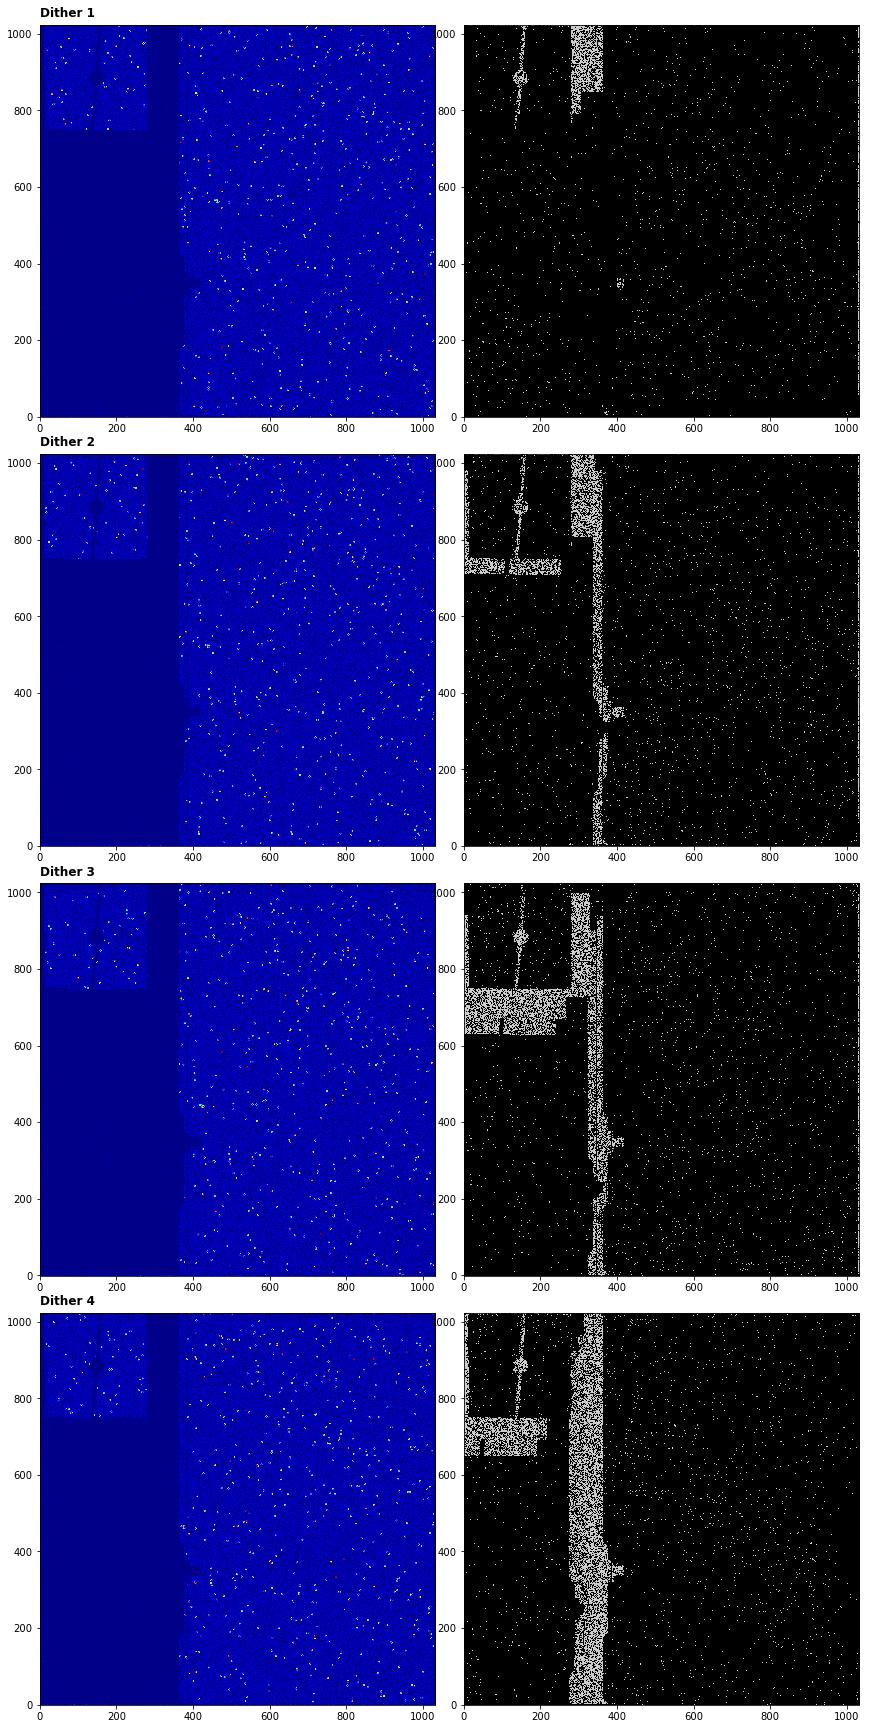

In [59]:
fig, axs = plt.subplots(4, 2, figsize=(12, 24))
axs = axs.ravel()

i,j = 0,0
for dm in dms:
    in_dm = in_dms[j]
    dith_num = j+1
    # plot image
    axs[i].imshow(dm.data, cmap='jet', interpolation='nearest', 
                  origin='lower', vmin=-1,vmax=100)
    axs[i].annotate('Dither %d' % dith_num, xy=(0.0, 1.02), xycoords='axes fraction', 
                    fontsize=12, fontweight='bold', color='k')
    axs[i].set_facecolor('black')
    i += 1
    
    # plot DQ array difference
    axs[i].imshow(dm.dq-in_dm.dq, cmap='gray', interpolation='nearest', 
                  origin='lower', vmin=0,vmax=5)
    axs[i].set_facecolor('black')
    i += 1
    
    j += 1 

plt.tight_layout()
plt.show()

## RESAMPLE step =======================================
This routine will resample each input 2D image based on the WCS and distortion information, and will combine multiple resampled images into a single undistorted product. The distortion information should have been incorporated into the image using the latest assign_wcs pipeline step. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/resample/index.html

The output of this step is a drizzled image.

### RESAMPLE: load module and show options

In [60]:
# import the step
from jwst.resample import resample_step

# print the description and options
print resample_step.ResampleStep.__doc__
print resample_step.ResampleStep.spec



    ResampleStep: Uses the drizzle process to resample (geometric correction)
    a single 2D image or resample and combine a set of 2D images specified as
    an association.

    Parameters
    -----------
    input : str or model
        Single filename for either a single image or an association table.
    

        single = boolean(default=False)
        wht_type = option('exptime','error',None,default='exptime')
        pixfrac = float(default=1.0)
        kernel = string(default='square')
        fillval = string(default='INDEF')
        good_bits = integer(default=4)
        blendheaders = boolean(default=True)
    


### RESAMPLE: run step

In [61]:
# run step
driz_im = resample_step.ResampleStep.call(dms, save_results=True, output_dir=output_dir, output_file='drizzled_image.fits')


2017-08-30 12:17:22,063 - stpipe.ResampleStep - INFO - ResampleStep instance created.
2017-08-30 12:17:23,075 - stpipe.ResampleStep - INFO - Prefetch for DRIZPARS reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_drizpars_0001.fits'.
2017-08-30 12:17:23,664 - stpipe.ResampleStep - INFO - Prefetch for DRIZPARS reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_drizpars_0001.fits'.
2017-08-30 12:17:24,281 - stpipe.ResampleStep - INFO - Prefetch for DRIZPARS reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_drizpars_0001.fits'.
2017-08-30 12:17:24,923 - stpipe.ResampleStep - INFO - Prefetch for DRIZPARS reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_drizpars_0001.fits'.
2017-08-30 12:17:25,190 - stpipe.ResampleStep - INFO - Step ResampleStep running with args (<jwst.datamodels.container.ModelContainer object at 0x117730050>,).
2017-08-30 12:17:26,20

### RESAMPLE: output checks

1. plot the output drizzled image

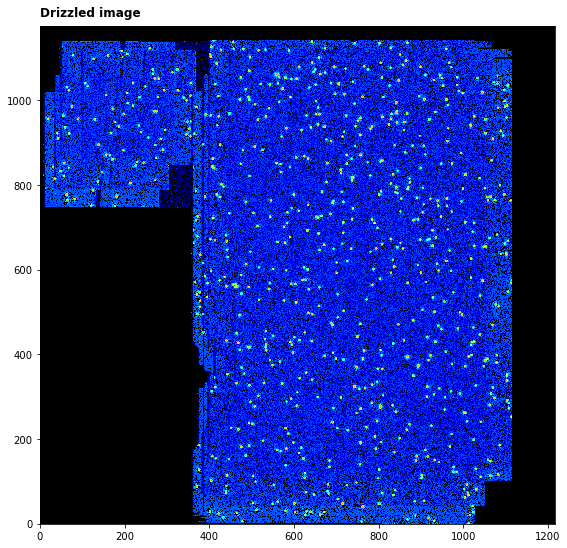

In [62]:
# plot--------------------------------------
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(driz_im.data, cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1,vmax=1000))
axs.annotate('Drizzled image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs.set_facecolor('black')

plt.tight_layout()
plt.show()

## SOURCE_CATALOG step =======================================
This step creates a final catalog of source photometry and morphologies. See:

http://ssb.stsci.edu/doc/jwst_dev/jwst/source_catalog/index.html


### SOURCE_CATALOG: load module and show options

In [63]:
# import the step
from jwst.source_catalog import source_catalog_step

# print the description and options
print source_catalog_step.SourceCatalogStep.__doc__
print source_catalog_step.SourceCatalogStep.spec



    Create a final catalog of source photometry and morphologies.

    Parameters
    -----------
    input : str or `DrizProductModel`
        A FITS filename or a `DrizProductModel` of a single drizzled
        image.  The input image is assumed to be background subtracted.
    

        kernel_fwhm = float(default=2.0)    # Gaussian kernel FWHM in pixels
        kernel_xsize = float(default=5)     # Kernel x size in pixels
        kernel_ysize = float(default=5)     # Kernel y size in pixels
        snr_threshold = float(default=3.0)  # SNR threshold above the bkg
        npixels = float(default=5.0)        # min number of pixels in source
        deblend = boolean(default=False)    # deblend sources?
    


### SOURCE_CATALOG: run step

In [64]:
# run step
source_catalog_step.SourceCatalogStep.call(driz_im, save_results=True, output_dir=output_dir)


2017-08-30 12:17:37,125 - stpipe.SourceCatalogStep - INFO - SourceCatalogStep instance created.
2017-08-30 12:17:37,385 - stpipe.SourceCatalogStep - INFO - Step SourceCatalogStep running with args (<jwst.datamodels.drizproduct.DrizProductModel object at 0x14a1e22d0>,).
2017-08-30 12:17:39,940 - stpipe.SourceCatalogStep - WARNING - /Users/patrickkavanagh/anaconda/envs/jwstb7.1rc2/lib/python2.7/site-packages/astropy/wcs/wcs.py:494: FITSFixedWarning: The WCS transformation has more axes (3) than the image it is associated with (2)
  wcsprm.naxis, header_naxis), FITSFixedWarning)

2017-08-30 12:17:40,928 - stpipe.SourceCatalogStep - INFO - Detected 682 sources
2017-08-30 12:17:40,986 - stpipe.SourceCatalogStep - INFO - Wrote source catalog: /Users/patrickkavanagh/github/build7.1rc2_notebooks_test/IMA_demo_data_steps_output/drizzled_image_cat.escv
2017-08-30 12:17:40,988 - stpipe.SourceCatalogStep - INFO - Step SourceCatalogStep done


### SOURCE_CATALOG: output checks

1. look at the source list
2. plot the source list over the drizzled image

#### look at source list

In [65]:
from astropy.table import Table

my_catalog = glob.glob(os.path.join(output_dir,'*.escv'))[0]
sources = Table.read(my_catalog, format='ascii.ecsv')

print sources

 id   xcentroid     ycentroid   ... orientation_sky     abmag     abmag_error
         pix           pix      ...       deg                                
--- ------------- ------------- ... --------------- ------------- -----------
  1 1011.47880844 1.58389221767 ...   275.393980462  17.500120163   0.0160891
  2 758.511706103 5.43425928145 ...   217.949256303 16.3200263977  0.00773224
  3 477.034542413 6.20267955505 ...   310.318164025 16.6953487396   0.0099828
  4 929.566141689 6.87046455532 ...   295.050649835  16.113740921  0.00669588
  5 866.994640495 10.2198407872 ...   213.004829156 16.8549098969   0.0116823
  6 916.560498459 13.9049354249 ...    217.09133171 16.0727100372  0.00645293
  7 432.072671567 15.0863350439 ...   306.131217052 15.7525548935  0.00512238
  8 884.991988134 19.5190252227 ...   345.939233457 16.3574733734  0.00782187
  9 627.139361903 24.0081585592 ...   342.251502182 15.6233005524  0.00578054
 10 661.042375209 21.3563212738 ...   337.842002174 15.922687530

#### plot source list on drizzled image

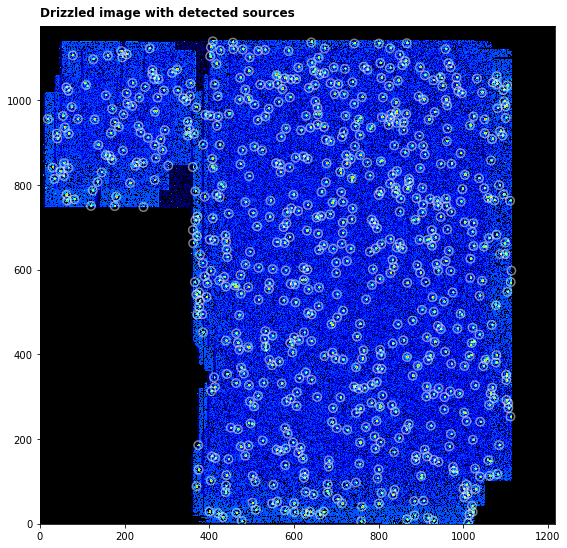

In [66]:
from photutils import CircularAperture

# read source X,Y positions from the table, show with circles of radius 10pix
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=10.)

# plot--------------------------------------
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(driz_im.data, cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1,vmax=1000))
apertures.plot(color='white', lw=1.5, alpha=0.5)
axs.annotate('Drizzled image with detected sources', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs.set_facecolor('black')

plt.tight_layout()
plt.show()